In [1]:
import numpy as np

In [2]:
train = np.load('padded_train_data_los.npy')

In [3]:
train.shape

(14681, 61, 18)

In [4]:
import os
import pandas as pd
import numpy as np

class ReadmissionReader:
    def __init__(self, root_dir, mode='train', seed=42):
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'"
        self.root_dir = root_dir
        self.mode_dir = os.path.join(root_dir, mode)
        self.seed = seed
        self.patient_files = self._get_patient_files()
        np.random.seed(seed)
        np.random.shuffle(self.patient_files)

    def _get_patient_files(self):
        patient_files = []
        for patient in os.listdir(self.mode_dir):
            patient_dir = os.path.join(self.mode_dir, patient)
            if os.path.isdir(patient_dir):
                patient_files.append(patient_dir)
        return patient_files

    def get_number_of_examples(self):
        return len(self.patient_files)

    def read_example(self, i):
        patient_dir = self.patient_files[i]
        patient_id = os.path.basename(patient_dir)
        episode_files = [f for f in os.listdir(patient_dir) if f.startswith('episode')]
        episode_timeseries_files = [f for f in episode_files if f.endswith('_timeseries.csv')]
        episode_timeseries_files.sort()

        # Check if there are any episode timeseries files
        if not episode_timeseries_files:
            return None

        # Load the first episode timeseries data
        episode1_timeseries_file = episode_timeseries_files[0]
        episode1_timeseries_path = os.path.join(patient_dir, episode1_timeseries_file)
        episode1_timeseries_data = pd.read_csv(episode1_timeseries_path)
        episode1_timeseries_data = episode1_timeseries_data.fillna('')
        # Get the header
        header = episode1_timeseries_data.columns.tolist()

        # Check if there are more than one episode timeseries files
        y_label = 1 if len(episode_timeseries_files) > 1 else 0

        # Get the total time
        total_time = float(episode1_timeseries_data.iloc[-1, 0])

        example = {
            'X': episode1_timeseries_data.values.astype(str),
            't': total_time,
            'y': y_label,
            'header': header,
            'name': f"{patient_id}_{episode1_timeseries_file}"
        }

        return example



In [5]:
dataset_dir = r"C:\Users\samit\OneDrive\Desktop\Datasets\data\decompensation"

root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [6]:
train_reader = ReadmissionReader(root_dir, mode='train')
test_reader = ReadmissionReader(root_dir, mode='test')
print("Number of training examples:", train_reader.get_number_of_examples())
print("Number of testing examples:", test_reader.get_number_of_examples())

Number of training examples: 28728
Number of testing examples: 5070


In [9]:
example = train_reader.read_example(0)

In [12]:
len(example['X'])

630

In [46]:
train_label =np.load('padded_test_data_pheno.npy')

In [50]:
train_label[0][0]

array([ 0.        ,  0.        , -0.7203045 ,  0.        ,  5.        ,
        5.        ,  0.34874293, 11.        , -3.613865  , -1.6303232 ,
        0.        , -0.505136  ,  0.3877461 , -0.2615161 ,  0.09907782,
        0.38630238,  0.        ,  0.        ], dtype=float32)

C:\Users\samit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

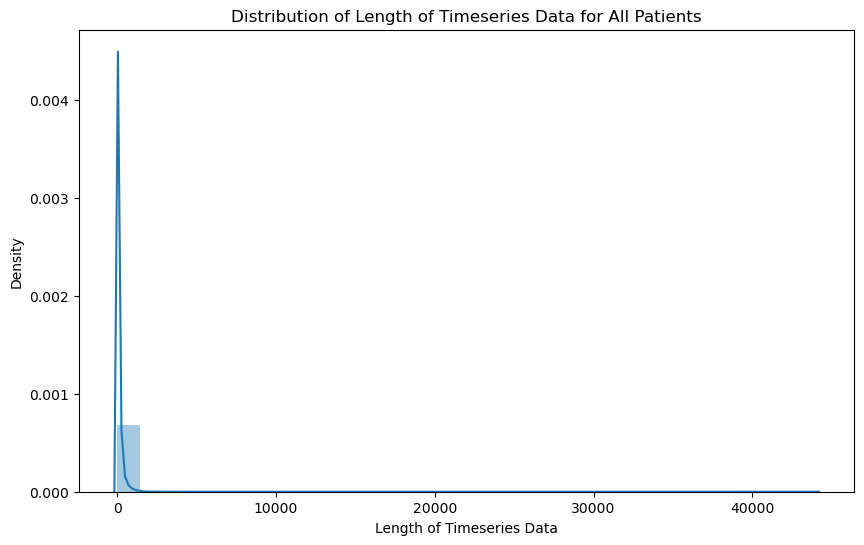

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the total number of examples
total_examples = train_reader.get_number_of_examples()

# Initialize a list to store the lengths of timeseries data for each patient
lengths = []
duration = []
# Loop through all the examples
for i in range(total_examples):
    example = train_reader.read_example(i)
    # Check if example is not None before accessing its keys
    if example is not None:
        # Append the length of the 'X' array to the lengths list
        lengths.append(len(example['X']))
        duration.append(example['t'])
# Plotting the distribution of lengths
plt.figure(figsize=(10, 6))
sns.distplot(lengths, bins=30, kde=True)
plt.title('Distribution of Length of Timeseries Data for All Patients')
plt.xlabel('Length of Timeseries Data')
plt.ylabel('Density')
plt.show



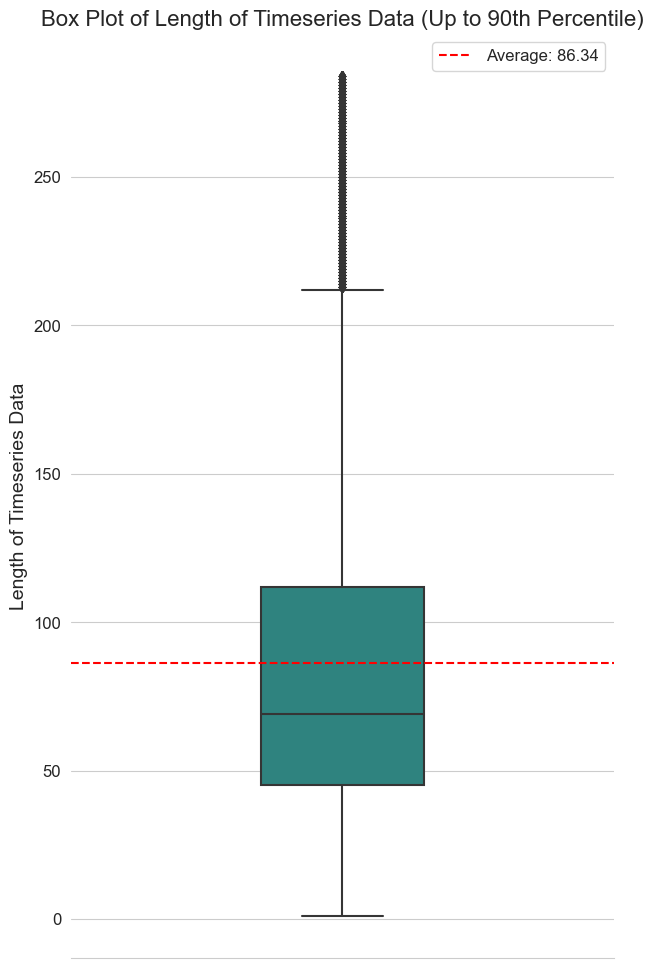

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("whitegrid")

# Calculate the 90th percentile
percentile_90 = np.percentile(lengths, 90)

# Filter the lengths list to include only values less than or equal to the 90th percentile value
filtered_lengths = [length for length in lengths if length <= percentile_90]

# Calculate the average of the filtered lengths
average_length = np.mean(filtered_lengths)

# Create the vertical box plot with a bright gradient color
plt.figure(figsize=(7, 12))
sns.boxplot(y=filtered_lengths, palette="viridis", width=0.3)

# Plot a horizontal line for the average and label it
plt.axhline(y=average_length, color='red', linestyle='--', label=f'Average: {average_length:.2f}')
plt.legend(loc='upper right', fontsize=12)

plt.title('Box Plot of Length of Timeseries Data (Up to 90th Percentile)', fontsize=16)
plt.ylabel('Length of Timeseries Data', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)

plt.show()





In [20]:
import numpy as np

# Calculate the 90th percentile
percentile_90 = np.percentile(lengths, 75)

print(f"The length at the 90th percentile is: {percentile_90}")


The length at the 90th percentile is: 138.0


In [28]:
from scipy.stats import percentileofscore

# Calculate the percentile rank of the value 142 in the filtered_lengths list
percentile_rank = percentileofscore(lengths, 142)

print(f"The value 142 captures the {percentile_rank:.2f}th percentile of the data.")


The value 142 captures the 75.98th percentile of the data.


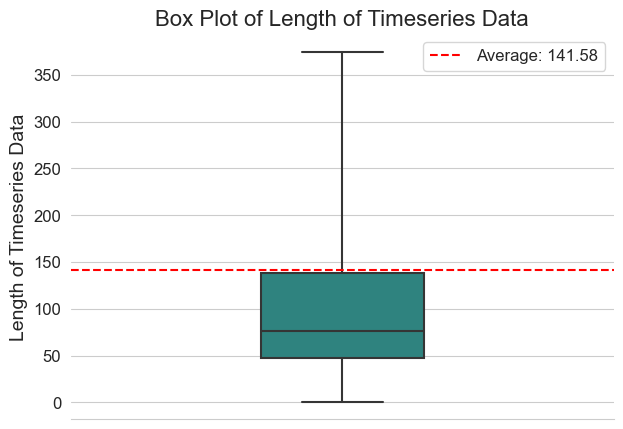

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("whitegrid")

# Calculate the 90th percentile
percentile_90 = np.percentile(lengths, 90)

# Calculate the interquartile range (IQR)
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

# Calculate the whis value such that it corresponds to the 90th percentile
whis_value = (percentile_90 - Q1) / IQR

# Create the vertical box plot with a bright gradient color without showing outliers above the 90th percentile
plt.figure(figsize=(7, 5))
sns.boxplot(y=lengths, palette="viridis", width=0.3, whis=whis_value, showfliers=False)

# Plot a horizontal line for the average and label it
average_length = np.mean(lengths)
plt.axhline(y=average_length, color='red', linestyle='--', label=f'Average: {average_length:.2f}')
plt.legend(loc='upper right', fontsize=12)

plt.title('Box Plot of Length of Timeseries Data', fontsize=16)
plt.ylabel('Length of Timeseries Data', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)

plt.show()


In [33]:
max(lengths)

44020

In [35]:
padded_test_data_read = np.load('padded_test_data.npy')
padded_train_data_read = np.load('padded_train_data.npy')
test_data_static_read = np.load('test_data_static.npy')
test_labels_read = np.load('test_labels.npy')
train_data_static_read = np.load('train_data_static.npy')

In [37]:
print(padded_test_data_read.shape)
print(padded_train_data_read.shape)
print(test_data_static_read.shape)
print(test_labels_read.shape)
print(train_data_static_read.shape)

(5066, 142, 18)
(28692, 142, 18)
(5066, 7)
(5066,)
(14681, 7)


In [39]:

padded_train_data_los = np.load('padded_train_data_los.npy')
#train_data_static_los = np.load('train_data_static_los.npy')
test_data_static_los = np.load('test_data_static_los.npy')
padded_test_data_los = np.load('padded_test_data_los.npy')
test_labels_los = np.load('test_labels_los.npy')
train_labels_los = np.load('train_labels_los.npy')
padded_val_data_los = np.load('padded_val_data_los.npy')
val_data_static_los = np.load('val_data_static_los.npy')
val_data_static_los = np.load('val_labels_los.npy')

In [42]:
print(padded_train_data_los.shape)
#print(train_data_static_los.shape)
print(test_data_static_los.shape)
print(padded_test_data_los.shape)
print(train_labels_los.shape)
print(test_labels_los.shape)
print(padded_val_data_los.shape)
print(val_data_static_los.shape)
print(val_data_static_los.shape)

(14681, 61, 18)
(3236, 7)
(3236, 61, 18)
(14681,)
(3236,)
(3222, 61, 18)
(3222,)
(3222,)


In [44]:
padded_test_data_pheno = np.load('padded_test_data_pheno.npy')
padded_train_data_pheno = np.load('padded_train_data_pheno.npy')
test_data_static_pheno = np.load('test_data_static_pheno.npy')
test_labels_pheno = np.load('test_labels_pheno.npy')
train_labels_pheno = np.load('train_labels_pheno.npy')
train_data_static_pheno = np.load('train_data_static_pheno.npy')

In [45]:
print(padded_test_data_pheno.shape)
print(padded_train_data_pheno.shape)
print(test_data_static_pheno.shape)
print(test_labels_pheno.shape)
print(train_labels_pheno.shape)
print(train_data_static_pheno.shape)

(6281, 142, 18)
(35621, 142, 18)
(6281, 8)
(6281, 25)
(35621, 25)
(35621, 8)


In [53]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [54]:
class InHospitalMortalityReader(Reader):
    def __init__(self, dataset_dir, listfile=None, period_length=48.0):
        """ Reader for in-hospital moratality prediction task.

        :param dataset_dir:   Directory where timeseries files are stored.
        :param listfile:      Path to a listfile. If this parameter is left `None` then
                              `dataset_dir/listfile.csv` will be used.
        :param period_length: Length of the period (in hours) from which the prediction is done.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(x, int(y)) for (x, y) in self._data]
        self._period_length = period_length

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : int (0 or 1)
                In-hospital mortality.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._period_length
        y = self._data[index][1]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}

In [55]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\in-hospital-mortality"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [56]:
train_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train_listfile.csv'),
                                         period_length=48.0)


val_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                       listfile=os.path.join(dataset_dir, 'val_listfile.csv'),
                                       period_length=48.0)

test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test_listfile.csv'),
                                       period_length=48.0)

In [58]:
import os
import pandas as pd

def get_los(data, root_dir, mode='train'):
    # Extract the patient ID and episode number from the 'name' field
    name_parts = data['name'].split('_')
    patient_id = name_parts[0]
    episode_number = name_parts[1]

    # Construct the path to the patient folder
    patient_folder = os.path.join(root_dir, mode, patient_id)

    # Load the episode data
    episode_path = os.path.join(patient_folder, f'{episode_number}.csv')
    episode_data = pd.read_csv(episode_path)

    # Get the ICU stay ID from the episode data
    icu_stay_id = episode_data['Icustay'].values[0]

    # Load the stays data
    stays_path = os.path.join(patient_folder, 'stays.csv')
    stays_data = pd.read_csv(stays_path)

    # Get the length of stay for the specific ICU stay ID
    los = stays_data[stays_data['ICUSTAY_ID'] == int(icu_stay_id)]['LOS'].values[0]

    return los

In [60]:
labels = np.load('train_labels_los.npy')

C:\Users\samit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


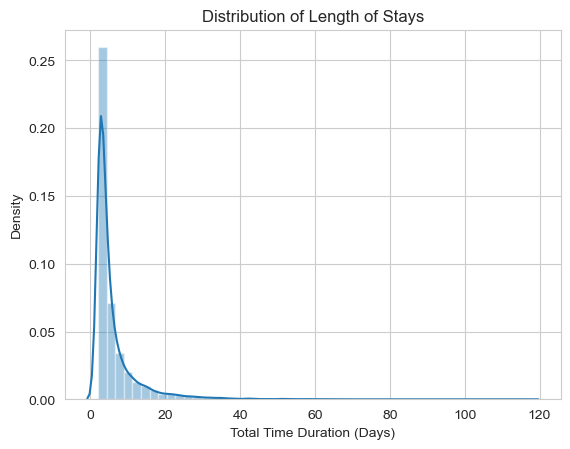

In [72]:
sns.distplot(labels)
plt.title('Distribution of Length of Stays')
plt.xlabel('Total Time Duration (Days)')
plt.show()